In [18]:
import os
import json
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

from visualization.utils import gradient_line, get_label_position

In [19]:
# Experiments where baseline was computed and where the metrics can be retrieved
POSTPROCESSING_EXPERIMENTS = {
    ('BPR', 'ML-1M'): 'metrics/ml-1m-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0001.json',
    ('DMF', 'ML-1M'): 'metrics/ml-1m-dmf/c0.0__frozen_itememb__selection_relevance__k100__lr0.0005.json',
    ('BPR', 'AMBAR'): 'metrics/ambar-bpr/c0.0__frozen_itememb__selection_relevance__k100__lr0.0001.json',
    ('DMF', 'AMBAR'): 'metrics/ambar-dmf/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json',
}

In [20]:
ALPHAS = [
    0.0,
    # 0.1,
    # 0.25,
    # 0.5,
    # 0.75,
    1.0
]

CANDIDATE_K = [
    25,
    50,
    100,
    200,
    400,
    1600
]

EXPERIMENTS_TO_SHOW = [
    {
        'model_class': 'BPR',
        'dataset': 'AMBAR',
        'lr': 'lr0.0001',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': CANDIDATE_K,
        'alphas': ALPHAS
    },
    {
        'model_class': 'BPR',
        'dataset': 'AMBAR',
        'lr': 'lr0.0005',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': CANDIDATE_K,
        'alphas': ALPHAS
    },
    {
        'model_class': 'BPR',
        'dataset': 'AMBAR',
        'lr': 'lr0.0001',
        'frozen_itememb': 'frozen_itememb',
        'k_candidates': CANDIDATE_K,
        'alphas': ALPHAS
    },
    {
        'model_class': 'BPR',
        'dataset': 'AMBAR',
        'lr': 'lr0.0005',
        'frozen_itememb': 'frozen_itememb',
        'k_candidates': CANDIDATE_K,
        'alphas': ALPHAS
    }
]

# Set to true to obtain plot only showing first and last result
EMERGENCY_MODE = False

if EMERGENCY_MODE:
    EXPERIMENTS_TO_SHOW.pop(2)
    EXPERIMENTS_TO_SHOW.pop(1)

data = {}

for idx, subplot in enumerate(EXPERIMENTS_TO_SHOW):
    model_class = subplot['model_class']
    dataset = subplot['dataset']
    lr = subplot['lr']
    frozen_itememb = subplot['frozen_itememb']
    k_candidates = subplot['k_candidates']
    alphas = subplot['alphas']

    data[idx] = {
        'base_model': model_class,
        'dataset': dataset,
        'finetuned': {}
    }

    metrics_folder = f'{dataset.lower()}-{model_class.lower()}'

    try:
        with open(POSTPROCESSING_EXPERIMENTS[(model_class, dataset)]) as f:
            experiment_data = json.load(f)
            data[idx]['base_model_metrics'] = {
                'ndcg': experiment_data['base_recommendations']['ndcg'],
                'jsd': experiment_data['base_recommendations']['jsd']
            }

            postprocessed_ndcgs = []
            postprocessed_jsds = []
            for l in experiment_data['postprocessed'].keys():
                postprocessed_ndcgs.append(experiment_data['postprocessed'][l]['ndcg'])
                postprocessed_jsds.append(experiment_data['postprocessed'][l]['jsd'])

            data[idx]['postprocessed'] = {
                'ndcg': postprocessed_ndcgs,
                'jsd': postprocessed_jsds
            }
    except FileNotFoundError:
        print('Experiment with Postprocessing data not found, skipping!')

    for alpha, k in product(alphas, k_candidates):
        experiment_name = f'c{alpha}__{frozen_itememb}__selection_relevance__k{k}__{lr}.json'
        experiment_file_loc = os.path.join('metrics', metrics_folder, experiment_name)
        try:
            with open(experiment_file_loc) as f:
                experiment_data = json.load(f)

                finetuned_ndcgs = []
                finetuned_jsds = []
                for epoch in experiment_data['finetuned'].keys():
                    finetuned_ndcgs.append(experiment_data['finetuned'][epoch]['ndcg'])
                    finetuned_jsds.append(experiment_data['finetuned'][epoch]['jsd'])

                data[idx]['finetuned'][(k, alpha)] = {
                    'ndcg': finetuned_ndcgs,
                    'jsd': finetuned_jsds
                }
        except FileNotFoundError:
            print(f'Experiment {experiment_file_loc} not found, skipping!')

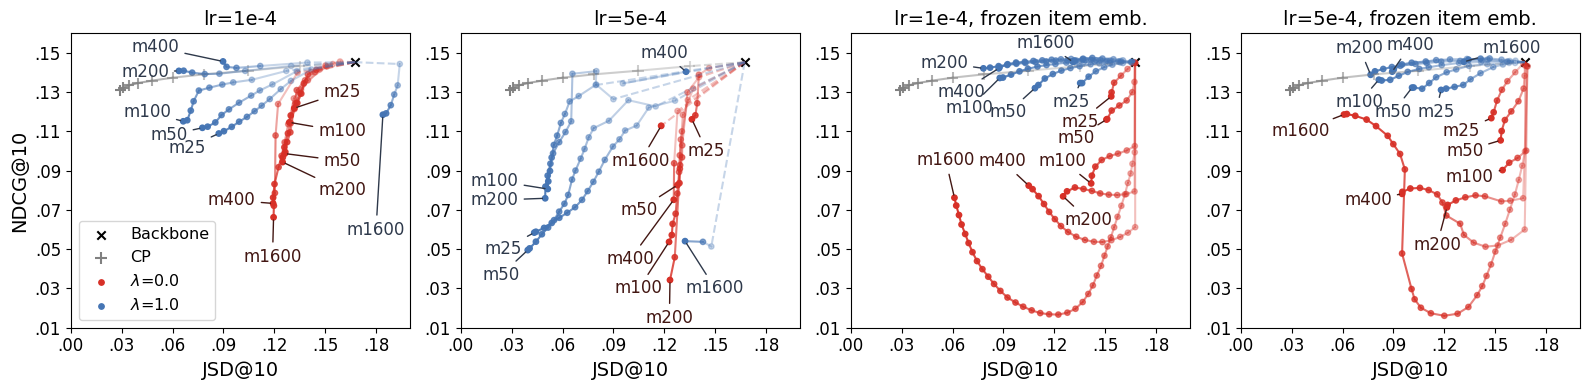

In [21]:
JSD_RANGE = [
    [0, 0.20],
    [0, 0.20],
    [0, 0.20],
    [0, 0.20]
]
NDCG_RANGE = [
    [0.01, 0.16],
    [0.01, 0.16],
    [0.01, 0.16],
    [0.01, 0.16],
]

LR_LABELS = {
    'lr0.0001': '1e-4',
    'lr0.0005': '5e-4',
    'lr1e-05': '1e-5',
}

ALPHA_COLORS = {
    0.0: '#d73027',
    0.1: '#f46d43',
    0.25: '#fdae61',
    0.5: '#fee090',
    0.75: '#74add1',
    1.0: '#4575b4'
}

ANNOTATION_ALPHA_COLORS = {
    0.0: '#431713',
    0.1: 'black',
    0.25: 'black',
    0.5: 'black',
    0.75: 'black',
    1.0: '#2e394b',
}

MANUAL_LABEL_POSITIONS = [
    {
        (0.0, 25): (0.16, 0.13),
        (0.0, 50): (0.16, 0.095),
        (0.0, 100): (0.16, 0.11),
        (0.0, 200): (0.16, 0.08),
        (0.0, 400): (0.095, 0.075),
        (1.0, 100): (0.045, 0.12),
        (1.0, 400): (0.05, 0.153),
        (1.0, 1600): (0.18, 0.06)
    },
    {
        (0.0, 25): (0.145, 0.10),
        (0.0, 50): (0.105, 0.07),
        (0.0, 100): (0.105, 0.03),
        (0.0, 200): (0.123, 0.015),
        (0.0, 400): (0.10, 0.045),
        (0.0, 1600): (0.106, 0.095),
        (1.0, 100): (0.02, 0.085),
        (1.0, 200): (0.02, 0.075),
        (1.0, 400): (0.12, 0.15),
        (1.0, 1600): (0.15, 0.03)
    },
    {
        (0.0, 25): (0.135, 0.115),
        (0.0, 100): (0.125, 0.095),
        (0.0, 200): (0.14, 0.065),
        (1.0, 25): (0.13, 0.125),
        (1.0, 100): (0.07, 0.122),
        (1.0, 200): (0.055, 0.145),
        (1.0, 400): (0.065, 0.13),
        (1.0, 1600): (0.115, 0.155),
    },
    {
        (0.0, 25): (0.13, 0.11),
        (0.0, 50): (0.132, 0.10),
        (0.0, 100): (0.135, 0.087),
        (0.0, 400): (0.075, 0.075),
        (0.0, 1600): (0.035, 0.11),
        (1.0, 25): (0.115, 0.12),
        (1.0, 50): (0.09, 0.12),
        (1.0, 100): (0.07, 0.125),
        (1.0, 200): (0.07, 0.1525),
        (1.0, 400): (0.10, 0.154),
        (1.0, 1600): (0.16, 0.1525),
    },
]

if EMERGENCY_MODE:
    MANUAL_LABEL_POSITIONS.pop(2)
    MANUAL_LABEL_POSITIONS.pop(1)

# Obtain 1x4 subplots
fig, axes = plt.subplots(1, len(EXPERIMENTS_TO_SHOW), figsize=(4 * len(EXPERIMENTS_TO_SHOW), 4))

for idx, experiment in enumerate(EXPERIMENTS_TO_SHOW):
    lr = experiment['lr']
    k_candidates = experiment['k_candidates']
    frozen = experiment['frozen_itememb']

    subplot_data = data[idx]

    ax = axes[idx]

    if frozen == 'frozen_itememb':
        frozen_label = ', frozen item emb.'
    else:
        frozen_label = ''  # Intentionally left blank

    ax.set_title(f'lr={LR_LABELS[lr]}{frozen_label}', fontsize=14)

    ax.set_xlabel('JSD@10', fontsize=14)
    if idx == 0:
        ax.set_ylabel('NDCG@10', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))

    ax.set_xlim(*JSD_RANGE[idx])
    ax.set_ylim(*NDCG_RANGE[idx])

    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.03), 2))

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.02), 2))

    starting_point = None
    # Plot Backbone Model
    if 'base_model_metrics' in subplot_data.keys():
        starting_point = [
            subplot_data['base_model_metrics']['jsd'],
            subplot_data['base_model_metrics']['ndcg']
        ]
        ax.scatter(
            starting_point[0],
            starting_point[1],
            marker='x', color='black', label='Backbone')

        # Plot postprocessing line
    if 'postprocessed' in subplot_data.keys():
        gradient_line(
            subplot_data['postprocessed']['jsd'],
            subplot_data['postprocessed']['ndcg'],
            ax,
            c='gray', marker='+', lbl='CP',
            starting_point=starting_point,
            scatter_size=65
        )

    for k, alpha in subplot_data['finetuned'].keys():
        finetuned_data = subplot_data['finetuned'][(k, alpha)]

        # Get color for alpha
        color = ALPHA_COLORS[alpha]

        if finetuned_data['jsd'][0] > 0.20:
            # Special treatment for lr0.0005, unfrozen item embedding and Pop mode k=1600:
            # Normally we always show the first and last point, and then sample results inbetween based on the euclidian distance between points
            # However, the very first point of this run is such a huge outlier at JSD almost of 0.25, and showing it takes a lot of space without
            # adding much information. Thus, we remove it here
            finetuned_data['jsd'] = finetuned_data['jsd'][1:]
            finetuned_data['ndcg'] = finetuned_data['ndcg'][1:]

        # Plot gradient line
        filtered_x, filtered_y = gradient_line(
            finetuned_data['jsd'],
            finetuned_data['ndcg'],
            ax,
            c=color, marker='o',
            lbl=f'$\lambda$={alpha}' if k == 100 else '',
            starting_point=starting_point,
            threshold=0.005,
        )

        # Plot annotation pointing to the last point with a simple line

        manual_label_position = MANUAL_LABEL_POSITIONS[idx].get((alpha, k), None)

        ax.annotate(
            f'm{k}',
            xy=[filtered_x[-1], filtered_y[-1]],
            c=ANNOTATION_ALPHA_COLORS[alpha],
            xytext=get_label_position(
                filtered_x[-1], filtered_y[-1],
                filtered_x[-2], filtered_y[-2],
                offset_length=0.02
            ) if manual_label_position is None else manual_label_position,
            fontsize=12,
            ha='center', va='center',
            arrowprops={
                'arrowstyle': '-',
                'color': ANNOTATION_ALPHA_COLORS[alpha],
                'lw': 1,
            },
        )

    if idx == 0:
        pass
        ax.legend(fontsize=11.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)  # smaller wspace leads to less horizontal padding
if EMERGENCY_MODE:
    plt.savefig('visualization/pdf/calitune_candidate_ablation_1x2_fallback.pdf')
else:
    plt.savefig('visualization/pdf/calitune_candidate_ablation_1x4.pdf')
plt.show()